# Apriori Algorithm Implementation Challenge

**Objective:** Implement the Apriori algorithm for association rule mining from scratch.

The Apriori algorithm works in three main phases:
1. **Candidate Generation**: Create potential itemsets of increasing size
2. **Support Counting**: Determine which itemsets meet minimum support
3. **Rule Generation**: Create association rules from frequent itemsets

### Apriori Principle
*"All subsets of a frequent itemset must also be frequent."*
This is key for pruning the search space.

In [19]:
import numpy as np
from itertools import combinations
from collections import defaultdict
import pandas as pd

# Sample dataset
transactions = [
    ['milk', 'bread', 'eggs'],
    ['milk', 'bread'],
    ['bread', 'eggs'],
    ['milk', 'eggs'],
    ['milk', 'bread', 'eggs', 'cheese'],
    ['cheese', 'eggs'],
    ['cheese'],
    ['milk', 'cheese', 'eggs']
]

# Preprocessing function (given)
def preprocess_transactions(transactions):
    return [list(set(t)) for t in transactions]

transactions = preprocess_transactions(transactions)
unique_items = list(set(item for t in transactions for item in t))

### Step 1: Implement Support Calculation

Complete the function below to calculate support for an itemset. (You should already have this)

In [20]:
def calculate_support(itemset, transactions):
    """
    Calculate the support of an itemset.
    
    Parameters:
    itemset (list): A list of items
    transactions (list): List of all transactions
    
    Returns:
    float: support count (between 0 and 1)
    """
    counter=0
    allPresent=True
    for transaction in transactions:
        for item in itemset:
            if item not in transaction:
                allPresent=False
                break
        if allPresent:
            counter+=1
        allPresent=True
    return counter/len(transactions)

# Test your function
print("Test support for ['milk']:", calculate_support(['milk'], transactions))

Test support for ['milk']: 0.625


### Step 2: Generate Candidate Itemsets

Implement the function to generate candidate itemsets of size k from frequent itemsets of size k-1.

In [21]:
def generate_candidates(prev_freq_itemsets, k):
    """
    Generate candidate itemsets of size k using frequent itemsets of size k-1.
    
    Parameters:
    prev_freq_itemsets (list): Frequent itemsets of size k-1
    k (int): The size of candidates to generate
    
    Returns:
    list: Candidate itemsets of size k
    """
    candidates = []
    n = len(prev_freq_itemsets)
    
    for i in range(n):
        for j in range(i + 1, n):
            # Merge two itemsets if their first k-2 items match
            # This helps avoid redundancy (just add eahc candidate 1 time)
            l1 = sorted(prev_freq_itemsets[i])
            l2 = sorted(prev_freq_itemsets[j])
            
            if l1[:k-2] == l2[:k-2]:
                candidate = sorted(list(set(l1) | set(l2)))
                if candidate not in candidates:
                    candidates.append(candidate)
    
    return candidates

# Test with k=2 (should print combinations of size 2)
print("Test candidates:", generate_candidates([['milk'], ['bread'], ['eggs']], 2))


Test candidates: [['bread', 'milk'], ['eggs', 'milk'], ['bread', 'eggs']]


### Step 3: Implement Pruning

Complete the pruning function using the Apriori principle.

In [22]:
def prune_candidates(candidates, prev_freq_itemsets, k):
    """
    Prune candidates whose subsets are not all frequent.
    
    Parameters:
    candidates (list): Candidate itemsets
    prev_freq_itemsets (list): Frequent itemsets of size k-1
    k (int): Size of the candidates
    
    Returns:
    list: Pruned candidate itemsets
    """
    pruned = []
    
    # Convert to set of tuples for faster lookup
    prev_freq_set = set(tuple(sorted(itemset)) for itemset in prev_freq_itemsets)
    
    for candidate in candidates:
        all_subsets_frequent = True
        
        # Generate all (k-1)-sized subsets
        for subset in combinations(candidate, k-1):
            if tuple(sorted(subset)) not in prev_freq_set:
                all_subsets_frequent = False
                break
        
        if all_subsets_frequent:
            pruned.append(candidate)
    
    return pruned

# Test pruning (should remove ['milk', 'cheese'] because 'cheese' is not in prev_freq_itemsets)
print("Test pruning:", prune_candidates([['milk', 'bread'], ['milk', 'cheese']], 
                                        [['milk'], ['bread'], ['eggs']], 2))


Test pruning: [['milk', 'bread']]


### Step 4: Complete the Apriori Algorithm

Implement the main function that ties all steps together.

In [23]:
def apriori(transactions, min_support=0.2):
    """
    The complete Apriori algorithm implementation.
    
    Parameters:
    transactions (list): List of transactions
    min_support (float): Minimum support threshold
    
    Returns:
    dict: A dictionary with keys as itemset sizes and values as frequent itemsets
    """

    # Generate initial 1-item frequent itemsets
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1
    
    num_transactions = len(transactions)
    freq_itemsets = []
    
    for item, count in item_counts.items():
        support = count / num_transactions
        if support >= min_support:
            freq_itemsets.append([item])

    result = {1: freq_itemsets}
    k = 2  # Size of itemsets to generate next

    while True:
        candidates = generate_candidates(result[k - 1], k)
        candidates = prune_candidates(candidates, result[k - 1], k)
        # Count support and collect frequent itemsets
        valid_itemsets = []
        for candidate in candidates:
            support = calculate_support(candidate, transactions)
            if support >= min_support:
                valid_itemsets.append(candidate)
        
        if not valid_itemsets:
            break
        
        result[k] = valid_itemsets
        k += 1

    return result

# Test the full algorithm
print("Apriori results:", apriori(transactions, 0.2))


Apriori results: {1: [['milk'], ['bread'], ['eggs'], ['cheese']], 2: [['bread', 'milk'], ['eggs', 'milk'], ['cheese', 'milk'], ['bread', 'eggs'], ['cheese', 'eggs']], 3: [['bread', 'eggs', 'milk'], ['cheese', 'eggs', 'milk']]}


### Step 5: Association Rule Generation

Implement rule generation from frequent itemsets.

In [24]:
def generate_rules(freq_itemsets, transactions, min_confidence=0.5):
    """
    Generate association rules from frequent itemsets.
    
    Parameters:
    freq_itemsets (dict): Frequent itemsets from apriori
    transactions (list): List of all transactions
    min_confidence (float): Minimum confidence threshold
    
    Returns:
    list: Association rules as dicts with keys 'antecedent', 'consequent', 'support', 'confidence'
    """
    rules = []

    for k, itemsets in freq_itemsets.items():
        if k < 2:
            continue
        
        for itemset in itemsets:
            itemset_support = calculate_support(itemset, transactions)
            
            # Generate all non-empty proper subsets (antecedents)
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = list(antecedent)
                    consequent = [item for item in itemset if item not in antecedent]
                    
                    antecedent_support = calculate_support(antecedent, transactions)
                    confidence = itemset_support / antecedent_support if antecedent_support > 0 else 0
                    
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedent': antecedent,
                            'consequent': consequent,
                            'support': itemset_support,
                            'confidence': confidence
                        })
    
    return rules

# Example test with your existing transactions and freq_itemsets:
freq_itemsets = {
    1: [['milk'], ['bread'], ['eggs']], 
    2: [['milk', 'bread'], ['bread', 'eggs']]
}
print("Test rules:", generate_rules(freq_itemsets, transactions, 0.5))


Test rules: [{'antecedent': ['milk'], 'consequent': ['bread'], 'support': 0.375, 'confidence': 0.6}, {'antecedent': ['bread'], 'consequent': ['milk'], 'support': 0.375, 'confidence': 0.75}, {'antecedent': ['bread'], 'consequent': ['eggs'], 'support': 0.375, 'confidence': 0.75}, {'antecedent': ['eggs'], 'consequent': ['bread'], 'support': 0.375, 'confidence': 0.5}]


## Final Testing

Run your complete implementation on the sample dataset and analyze the results.

In [25]:
# Test the complete workflow
freq_itemsets = apriori(transactions, 0.2)
rules = generate_rules(freq_itemsets, transactions, 0.5)

# Display results
print("Frequent Itemsets:")
for size, itemsets in freq_itemsets.items():
    print(f"Size {size}: {itemsets}")

print("\nAssociation Rules:")
for rule in rules:
    print(f"{rule['antecedent']} => {rule['consequent']} "
          f"(supp: {rule['support']:.2f}, conf: {rule['confidence']:.2f})")

Frequent Itemsets:
Size 1: [['milk'], ['bread'], ['eggs'], ['cheese']]
Size 2: [['bread', 'milk'], ['eggs', 'milk'], ['cheese', 'milk'], ['bread', 'eggs'], ['cheese', 'eggs']]
Size 3: [['bread', 'eggs', 'milk'], ['cheese', 'eggs', 'milk']]

Association Rules:
['bread'] => ['milk'] (supp: 0.38, conf: 0.75)
['milk'] => ['bread'] (supp: 0.38, conf: 0.60)
['eggs'] => ['milk'] (supp: 0.50, conf: 0.67)
['milk'] => ['eggs'] (supp: 0.50, conf: 0.80)
['cheese'] => ['milk'] (supp: 0.25, conf: 0.50)
['bread'] => ['eggs'] (supp: 0.38, conf: 0.75)
['eggs'] => ['bread'] (supp: 0.38, conf: 0.50)
['cheese'] => ['eggs'] (supp: 0.38, conf: 0.75)
['eggs'] => ['cheese'] (supp: 0.38, conf: 0.50)
['bread'] => ['eggs', 'milk'] (supp: 0.25, conf: 0.50)
['bread', 'eggs'] => ['milk'] (supp: 0.25, conf: 0.67)
['bread', 'milk'] => ['eggs'] (supp: 0.25, conf: 0.67)
['eggs', 'milk'] => ['bread'] (supp: 0.25, conf: 0.50)
['cheese'] => ['eggs', 'milk'] (supp: 0.25, conf: 0.50)
['cheese', 'eggs'] => ['milk'] (supp: 0.

# Apriori Algorithm Implementation Challenge (part2)

**Objective:** Implement the Apriori algorithm for association rule mining from scratch.

The Apriori algorithm works in three main phases:
1. **Candidate Generation**: Create potential itemsets of increasing size
2. **Support Counting**: Determine which itemsets meet minimum support
3. **Rule Generation**: Create association rules from frequent itemsets

### Apriori Principle
*"All subsets of a frequent itemset must also be frequent."*
This is key for pruning the search space.

In [26]:
import pandas as pd

# Sample dataset
transactions = [
    ['milk', 'bread', 'eggs'],
    ['milk', 'bread'],
    ['bread', 'eggs'],
    ['milk', 'eggs'],
    ['milk', 'bread', 'eggs', 'cheese'],
    ['cheese', 'eggs'],
    ['cheese'],
    ['milk', 'cheese', 'eggs']
]

# Preprocessing function (given)
def preprocess_transactions(transactions):
    return [list(set(t)) for t in transactions]

transactions = preprocess_transactions(transactions)
unique_items = list(set(item for t in transactions for item in t))

## Additional Assignments

1. **Rule Metrics**:
   - Extend your implementation to calculate lift and conviction for rules
   - Identify the top 5 most interesting rules by different metrics

In [ ]:

# the same function as above just adding lift and conviction
def enhanced_generate_rules(freq_itemsets, transactions, min_confidence=0.5):
    rules = []

    for k, itemsets in freq_itemsets.items():
        if k < 2:
            continue

        for itemset in itemsets:
            itemset_support = calculate_support(itemset, transactions)
            
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = list(antecedent)
                    consequent = [item for item in itemset if item not in antecedent]

                    antecedent_support = calculate_support(antecedent, transactions)
                    consequent_support = calculate_support(consequent, transactions)
                    
                    confidence = itemset_support / antecedent_support if antecedent_support > 0 else 0
                    lift = confidence / consequent_support if consequent_support > 0 else 0 # calculating lift from the formula
                    conviction = ((1 - consequent_support) / 
                                  (1 - confidence)) if (1 - confidence) != 0 else float('inf')  # calculating conviction from the formula

                    if confidence >= min_confidence:
                        rules.append({
                            'antecedent': antecedent,
                            'consequent': consequent,
                            'support': round(itemset_support, 4),
                            'confidence': round(confidence, 4),
                            'lift': round(lift, 4),
                            'conviction': round(conviction, 4)
                        })

    return rules

def analyze_top_rules():
    freq_itemsets = apriori(transactions, 0.2)
    rules = enhanced_generate_rules(freq_itemsets, transactions, 0.5)
    
    # Convert to DataFrame for easier analysis
    rules_df = pd.DataFrame(rules)
    
    print("Top 5 Rules by Support:")
    print(rules_df.sort_values(by='support', ascending=False).head(5))

    print("\nTop 5 Rules by Confidence:")
    print(rules_df.sort_values(by='confidence', ascending=False).head(5))

    print("\nTop 5 Rules by Lift:")
    print(rules_df.sort_values(by='lift', ascending=False).head(5))
analyze_top_rules()

Top 5 Rules by Support:
  antecedent consequent  support  confidence    lift  conviction
2     [eggs]     [milk]    0.500      0.6667  1.0667       1.125
3     [milk]     [eggs]    0.500      0.8000  1.0667       1.250
0    [bread]     [milk]    0.375      0.7500  1.2000       1.500
6     [eggs]    [bread]    0.375      0.5000  1.0000       1.000
1     [milk]    [bread]    0.375      0.6000  1.2000       1.250

Top 5 Rules by Confidence:
        antecedent consequent  support  confidence    lift  conviction
15  [cheese, milk]     [eggs]    0.250        1.00  1.3333         inf
3           [milk]     [eggs]    0.500        0.80  1.0667        1.25
0          [bread]     [milk]    0.375        0.75  1.2000        1.50
5          [bread]     [eggs]    0.375        0.75  1.0000        1.00
7         [cheese]     [eggs]    0.375        0.75  1.0000        1.00

Top 5 Rules by Lift:
        antecedent consequent  support  confidence    lift  conviction
15  [cheese, milk]     [eggs]    0.250 

2. **Dataset Exploration**: 
   - Test your implementation on a larger dataset (groceries dataset from arules package)
   - Compare the number of frequent itemsets at different support thresholds

In [28]:
#Here we download data
import requests
url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/groceries.csv'
grocery_dataset = requests.get(url)
# Save string as txt file
f = open('grocery_dataset.txt','w')
f.write(grocery_dataset.text)
f.close()

In [29]:
#Here we format data so that our algorithm can use it
gr0 = []
with open('grocery_dataset.txt', 'r') as f:
    for line in f:
        # Strip newline and whitespace, then split by comma
        items = line.strip().split(',')
        gr0.append(items)
        
gr0 = preprocess_transactions(gr0)
print(gr0)

[['semi-finished bread', 'margarine', 'ready soups', 'citrus fruit'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['cream cheese ', 'pip fruit', 'yogurt', 'meat spreads'], ['other vegetables', 'long life bakery product', 'condensed milk', 'whole milk'], ['butter', 'yogurt', 'abrasive cleaner', 'whole milk', 'rice'], ['rolls/buns'], ['other vegetables', 'rolls/buns', 'UHT-milk', 'bottled beer', 'liquor (appetizer)'], ['pot plants'], ['whole milk', 'cereals'], ['other vegetables', 'chocolate', 'white bread', 'bottled water', 'tropical fruit'], ['dishes', 'butter', 'yogurt', 'whole milk', 'curd', 'bottled water', 'flour', 'tropical fruit', 'citrus fruit'], ['beef'], ['soda', 'rolls/buns', 'frankfurter'], ['chicken', 'tropical fruit'], ['fruit/vegetable juice', 'sugar', 'butter', 'newspapers'], ['fruit/vegetable juice'], ['packaged fruit/vegetables'], ['chocolate'], ['specialty bar'], ['other vegetables'], ['pastry', 'butter milk'], ['whole milk'], ['newspapers', 'cream cheese 

In [30]:
print(gr0)

[['semi-finished bread', 'margarine', 'ready soups', 'citrus fruit'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['cream cheese ', 'pip fruit', 'yogurt', 'meat spreads'], ['other vegetables', 'long life bakery product', 'condensed milk', 'whole milk'], ['butter', 'yogurt', 'abrasive cleaner', 'whole milk', 'rice'], ['rolls/buns'], ['other vegetables', 'rolls/buns', 'UHT-milk', 'bottled beer', 'liquor (appetizer)'], ['pot plants'], ['whole milk', 'cereals'], ['other vegetables', 'chocolate', 'white bread', 'bottled water', 'tropical fruit'], ['dishes', 'butter', 'yogurt', 'whole milk', 'curd', 'bottled water', 'flour', 'tropical fruit', 'citrus fruit'], ['beef'], ['soda', 'rolls/buns', 'frankfurter'], ['chicken', 'tropical fruit'], ['fruit/vegetable juice', 'sugar', 'butter', 'newspapers'], ['fruit/vegetable juice'], ['packaged fruit/vegetables'], ['chocolate'], ['specialty bar'], ['other vegetables'], ['pastry', 'butter milk'], ['whole milk'], ['newspapers', 'cream cheese 

In [31]:
#Here we format data to create ohe matrix to be used in the apriori function built in for comparison (if you want)
import csv
grocery_items = set()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        grocery_items.update(line)
output_list = list()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_val = {item:0 for item in grocery_items}
        row_val.update({item:1 for item in line})
        output_list.append(row_val)
grocery_df = pd.DataFrame(output_list)

In [32]:
# Test the complete workflow
freq_itemsets = apriori(gr0, 0.02)
rules = generate_rules(freq_itemsets, gr0, 0.05)

# Display results
print("Frequent Itemsets:")
for size, itemsets in freq_itemsets.items():
    print(f"Size {size}: {itemsets}")

print("\nAssociation Rules:")
for rule in rules:
    print(f"{rule['antecedent']} => {rule['consequent']} "
          f"(supp: {rule['support']:.2f}, conf: {rule['confidence']:.2f})")

Frequent Itemsets:
Size 1: [['margarine'], ['citrus fruit'], ['tropical fruit'], ['yogurt'], ['coffee'], ['whole milk'], ['cream cheese '], ['pip fruit'], ['other vegetables'], ['long life bakery product'], ['butter'], ['rolls/buns'], ['UHT-milk'], ['bottled beer'], ['chocolate'], ['white bread'], ['bottled water'], ['curd'], ['beef'], ['soda'], ['frankfurter'], ['chicken'], ['fruit/vegetable juice'], ['sugar'], ['newspapers'], ['specialty bar'], ['pastry'], ['butter milk'], ['candy'], ['salty snack'], ['waffles'], ['root vegetables'], ['canned beer'], ['sausage'], ['shopping bags'], ['brown bread'], ['beverages'], ['hygiene articles'], ['hamburger meat'], ['napkins'], ['pork'], ['whipped/sour cream'], ['berries'], ['grapes'], ['dessert'], ['domestic eggs'], ['misc. beverages'], ['hard cheese'], ['cat food'], ['ham'], ['oil'], ['chewing gum'], ['ice cream'], ['frozen vegetables'], ['specialty chocolate'], ['frozen meals'], ['onions'], ['sliced cheese'], ['meat']]
Size 2: [['margarine',

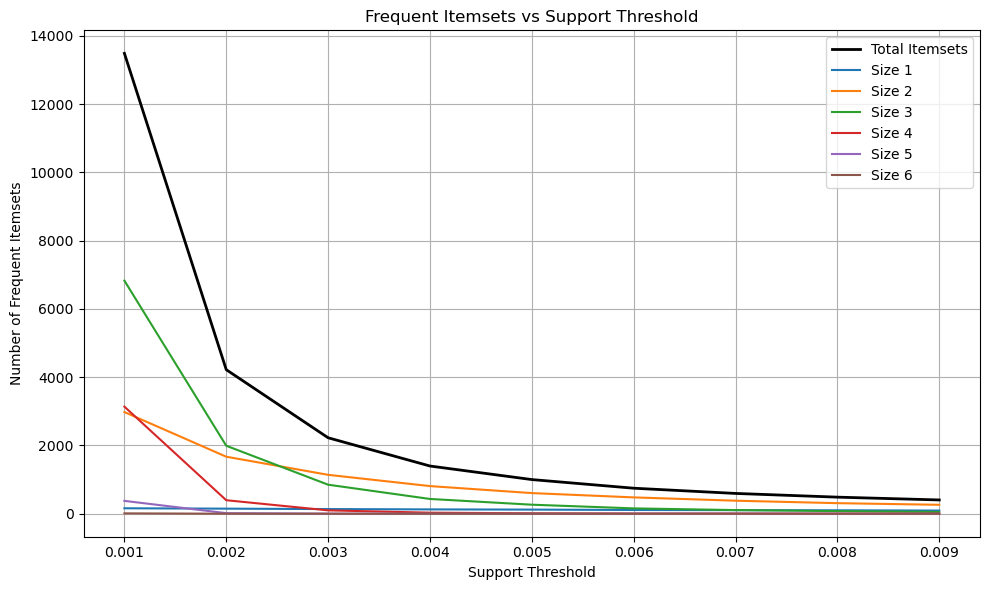

In [ ]:
import matplotlib.pyplot as plt

def plot_itemset_counts_by_size(transactionss, min_support=0.001, max_support=0.01, step=0.001, max_itemset_size=7):
    support_thresholds = []
    itemset_counts = {k: [] for k in range(1, max_itemset_size + 1)}
    total_counts = []

    support = min_support

    # loop calculating the amount of items for each support threshold and for each itemset size
    while support <= max_support:
        freq_itemsets = apriori(transactionss, min_support=support)
        support_thresholds.append(round(support, 4))
        total = 0

        for k in range(1, max_itemset_size + 1):
            count = len(freq_itemsets.get(k, []))
            itemset_counts[k].append(count)
            total += count
        
        total_counts.append(total)
        support += step

    plt.figure(figsize=(10, 6))
    plt.plot(support_thresholds, total_counts, label='Total Itemsets', color='black', linewidth=2)
    

    # plotting the results if and only if there is something to plot
    for k in range(1, max_itemset_size + 1):
        if any(itemset_counts[k]):
            plt.plot(support_thresholds, itemset_counts[k], label=f'Size {k}')
    
    plt.xlabel('Support Threshold')
    plt.ylabel('Number of Frequent Itemsets')
    plt.title('Frequent Itemsets vs Support Threshold')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return itemset_counts

# Example usage
itemset_counts = plot_itemset_counts_by_size(gr0)


3. **Algorithm Analysis**:
   - Add timing measurements of the algorithm
   - Plot how runtime changes with different support thresholds

Support 0.0100 -> Time: 9.2772s
Support 0.0150 -> Time: 5.7140s
Support 0.0200 -> Time: 3.7163s
Support 0.0250 -> Time: 3.2512s
Support 0.0300 -> Time: 2.1130s
Support 0.0350 -> Time: 1.4355s
Support 0.0400 -> Time: 0.9383s
Support 0.0450 -> Time: 1.0624s
Support 0.0500 -> Time: 0.9741s


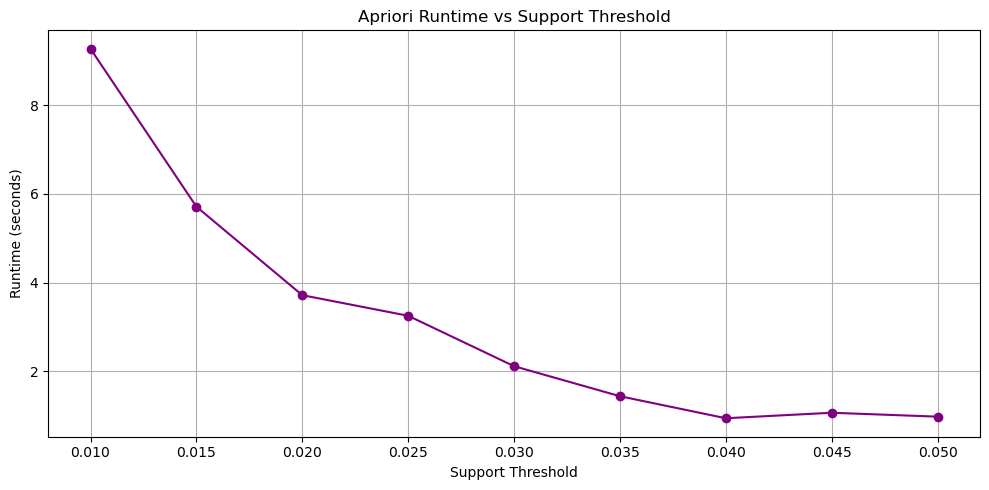

In [ ]:
import time
import matplotlib.pyplot as plt

def analyze_apriori_runtime(transactions, min_support=0.005, max_support=0.05, step=0.005):
    support_thresholds = [] # will be storing diffrent support tresholds we measured
    runtimes = [] # the measured runtimes

    support = min_support
    while support <= max_support:
        start_time = time.time()
        _ = apriori(transactions, min_support=support)
        end_time = time.time()

        elapsed = end_time - start_time # calculating the time needed to run the apriori
        support_thresholds.append(round(support, 4))
        runtimes.append(elapsed)

        print(f"Support {support:.4f} -> Time: {elapsed:.4f}s")
        support += step

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(support_thresholds, runtimes, marker='o', linestyle='-', color='purple')
    plt.xlabel('Support Threshold')
    plt.ylabel('Runtime (seconds)')
    plt.title('Apriori Runtime vs Support Threshold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return list(zip(support_thresholds, runtimes))

# Run it
runtime_stats = analyze_apriori_runtime(gr0, min_support=0.01, max_support=0.05, step=0.005)
